In [42]:
import basics
import sys
import jinja2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import csv
import sqlite3 as lite
from collections import OrderedDict

In [ ]:
def import_csv(csv_file):
    """
    Function imports the contents of a csv file as a dataframe.
    
    Input:
    csv_file: name of the csv file of interest.
    
    Output:
    reactor_data: the data contained in the csv file as a dataframe
    
    note:  this function requires pandas imported as pd
    
    """
    
    # This function takes the contents of the csv file and reads them into a dataframe.
    # one important thing to note is that the functions used later, specifically write_reactor
    # and write_region, expect that the header name for country, reactor name, reactor type,
    # net electric capacity, and operator are 'Country', 'Reactor Name', 'Type',
    # 'Net Electric Capacity', and 'Operator, respectively.  These headers are used
    # to find values within the dataframe.
    
    reactor_data = (pd.read_csv(csv_file, names=['Country','Reactor Name','Type',
                                                 'Net Electric Capacity','Operator'], skiprows=[0] ))
    
    return reactor_data

In [ ]:
def load_template(template):
    """
    Function reads a jinja2 template.
    
    Input:
    template: filename of the desired jinja2 template
    
    Output:  jinja2 template
    """
    
    # this function only really has one step, which is to read the desired jinja2 template
    # from file and return it.  This function doesn't really get used on its own, rather,
    # it is called from within functions that render portions of the Cyclus input file.
    with open(template,'r') as input_template:
        output_template = jinja2.Template(input_template.read())
        
    return output_template

In [ ]:
reactor_data = import_csv('test_data.csv')

In [ ]:
deployment_data = {}
for element in reactor_data.loc[:,'Country']:
    deployment_data[element] = [1,1,1]
        
print(deployment_data)

In [ ]:
print(reactor_data)
print()
print(reactor_data.loc[:,['Operator','Country','Reactor Name','Number Reactors']])
print()
print()
operators = {}
for element in range(len(reactor_data)):
    operators.update({reactor_data.iloc[element].loc['Operator']:
                      reactor_data.iloc[element].loc[['Country','Reactor Name','Number Reactors']]})

print(operators['SeveralBees'][0])

In [ ]:
def write_region(reactor_data,deployment_data,region_template,output_name = 'rendered-region.xml'):
    """
    
    ***Warning!  This function will check to see if there is already a file 'output_name' in the current directory,
    and if one is found it will be deleted.  Please be aware of this when choosing file names.***
    
    Function renders the region portion of the Cyclus input file.
    
    Input:
    reactor_data: the reactor data, as a pandas dataframe.
    deployment data: Dictionary object giving values for initial deployment of each facility type,
                    key names: n_mine, n_enrichment, n_reactor, n_repository
    region_template: name of region template file
    output_name: filenname of rendered region, default: 'rendered-region.xml'
    
    Output:
    rendered region input filename
    
    """
    # first, if the file output_name already exists, it is deleted.
    if os.path.exists('./'+ output_name) is True:
        os.remove(output_name)
    
    # then the region template is loaded.
    template = load_template(region_template)
    
    # the function splits between multiple and single data sets, then renders the region and writes
    # it to the file output_name.  .iloc and .loc are used to obtain specific elements within the
    # reactor_data dataframe.
    
    operators = {}
    for element in range(len(reactor_data)):
        operators.update({reactor_data.iloc[element].loc['Operator']:
                          reactor_data.iloc[element].loc[['Country','Reactor Name','Number Reactors']]})
    
    
    region_body = template.render(operators = operators,
                                 countries_infra = deployment_data)
    
    with open(output_name, 'a+') as output:
        output.write(region_body)
        
    #the filename of the rendered region file is returned to be used as an input later
    return output_name

In [ ]:
write_region(reactor_data,deployment_data,'region_template_t.xml')

In [ ]:
print(deployment_data)

In [ ]:
A = [ [1, 2, 3, 4, 5], [1,2,3,4,5], [1, 2, 3, 4, 4], [5,2, 4,5,5] ]

for element in range(len(A) - 1):
    if A[element] in A[(element+1):]:
        del A[element]
        
print(A)

# the above should remove duplicates, but unfortunately, I'm not sure how to also add the ability to count how
# many of that duplicate there were and append it (in practice, this would be to automate getting the
# number of a particular reactor in a country under a particular operator)
# because the reactor portion doesn't care about number, just that it can't have duplicates,
# this should work for that function

In [ ]:
A = [1, 2, 3, 4]
print(A[(0+1):])

In [ ]:
reactor_data = reactor_data.drop(['Type'],'columns')

#the above should work for inside the write reactors function to keep only the reactor name, type, and capacity info

#print(reactor_data.iloc[0])
print()
print()
print(len(reactor_data))
print()
print()
print(reactor_data.iloc[0:])

In [ ]:
B = reactor_data.groupby(reactor_data.columns.tolist()).size().reset_index().rename(columns={0:'Number Reactors'})
print(B)

In [ ]:
reactor_data = reactor_data.drop_duplicates()
#the above drops duplicate rows, (aka, duplicate data sets) but you can also specify what columns (by reactor name,
# or by type, for example) it checks for duplicates against
print(reactor_data)

In [ ]:
reactor_data = reactor_data.drop(['Country', 'Operator'],'columns')
reactor_data = reactor_data.drop_duplicates()
print(reactor_data)

In [ ]:
reactor_data = reactor_data.drop(['Type'],'columns')
reactor_data = reactor_data.groupby(reactor_data.columns.tolist()).size().reset_index().rename(columns={0:'Number Reactors'})
print(reactor_data)
print()
print()

### Error here in declaring operators: it's only making dictionaries for one of the two countries, not all operators in both
operators = {}
for element in range(len(reactor_data)):
    operators.update({reactor_data.iloc[element].loc['Operator']:
                        reactor_data.iloc[element].loc[['Country','Reactor Name','Number Reactors','Net Electric Capacity']]})

print(operators)



In [ ]:
print(len(reactor_data))
print()
print(len(operators))

In [ ]:
country_reactors = {}
countries_keys = reactor_data.loc[:,'Country'].drop_duplicates()
operator_keys = reactor_data.loc[:,'Operator'].drop_duplicates()


for country in countries_keys.tolist():
    
    country_operators = {}
    for operator in operator_keys.tolist():
        
        reactor_dict = {}
        data_loop = reactor_data.query('Country == @country & Operator == @operator ')
        
        for element in range(len(data_loop)):
            reactor_dict[data_loop.iloc[element,:].loc['Reactor Name']] = [data_loop.iloc[element,:].loc['Number Reactors'] , 
                                                                           data_loop.iloc[element,:].loc['Net Electric Capacity'] ]
        
        country_operators[operator] = reactor_dict
    
    country_reactors[country] = country_operators
    
print(country_reactors)

In [ ]:
country = 'The Beehive'
operator = 'SeveralBees'

print(reactor_data.query('Country == @country & Operator == @operator '))

In [2]:
cur = basics.get_cursor('singlereactortutorial.sqlite')

In [ ]:
agent_ids = basics.get_agent_ids(cur, "Enrichment")
print(agent_ids)

In [ ]:
resources = cur.execute(basics.exec_string('53',
                                            'transactions.receiverId',
                                            'time, sum(quantity), '
                                            'qualid') +
                                ' GROUP BY time, qualid').fetchall()

print(resources)

In [ ]:
print(len(agent_ids))
print()
print(len(agent_ids[0]))
print()
print()
A = ['strawberry','blueberry','raspberry']
print(len(A))
print(len(A[0]))
print()
for berry in A[0:]:
    print(berry)

In [ ]:
query = basics.exec_string(agent_ids[0],'transactions.receiverId',
                   'time, sum(quantity), '
                           'qualid')

print(query)

In [ ]:
A = [1]
print(len(A))

In [ ]:
import cymetric as cym

In [ ]:
db = cym.dbopen('singlereactortutorial.sqlite')

In [ ]:
material_df = cym.eval('Materials',db, conds = [('AgentId','==', agent_ids[0])])
print(material_df)

In [ ]:
filtered_frame = cym.eval('Resources', db, conds=[('AgentId', '==', 53)])
print(filtered_frame)

In [ ]:
## this information here should be like what you would get from the raw sqlite query
d = {'X':['A','A','A','A','A','A','B','B','B','B','B','B']
     ,'Y':[1,1,1,2,2,2,1,1,1,2,2,2],'Z':[1,2,3,4,5,6,7,8,9,10,11,12]}

In [ ]:
# this is the pandas df version of the sqlite table query
test = pd.DataFrame(data = d)
print(test)

In [ ]:
intertest = test.drop_duplicates(['X','Y'])
print(intertest)

In [ ]:
check = test[(test.X == 'A') & (test.Y == 1)].sum().loc['Z']
print(check)

In [ ]:
print(intertest.index)

In [ ]:
for row in intertest.index:
    xvalue = intertest.loc[row,'X']
    yvalue = intertest.loc[row,'Y']
    check = test[(test.X == xvalue) & (test.Y == yvalue)].sum().loc['Z']
    intertest.loc[row,'Z'] = check
#intertest.loc[(intertest.X == 'A') & (intertest.Y == 1), 'Z'] = check
print(intertest)

## This lumps up entries in the right way, if I can insert the other time values as zero mass points,
## this method should work for analysis

In [40]:
cur = lite.connect('singlereactortutorial.sqlite')

In [ ]:
B = ("B" + "L" + 
     "A" + "H")
print(B)

In [ ]:
facility = 'EnrichmentPlant'
agent_ids = cur.execute("SELECT agentid FROM AgentEntry WHERE Prototype = ?",(facility,)).fetchall()
print(agent_ids)
print(type(agent_ids))
print(str(agent_ids[0]))
print(type(str(agent_ids[0])))


In [ ]:

influx_bool = False

if influx_bool == True:
    flux = 'receiverid'
else:
    flux = 'senderid'


query = ("SELECT transactions.senderid as Agent, transactions.time, resources.quantity " + 
                              "FROM resources INNER JOIN transactions " + 
                              "ON transactions.resourceid = resources.resourceid " +
                              "WHERE transactions." + flux + " == " + str(agent_ids[0][0]) )
for agents in agent_ids[1:]:
    query+= " or transactions." + flux + " == " + str(agents[0])

print(query)
resources = pd.read_sql_query(query,cur)
print(resources)

In [ ]:
## copying the steps from the test above, but with real data
resources = pd.read_sql_query("SELECT transactions.senderid as Agent, transactions.time, resources.quantity " + 
                              "FROM resources INNER JOIN transactions " + 
                              "ON transactions.resourceid = resources.resourceid " +
                              "WHERE transactions.senderid == 58 or transactions.senderid == 53",cur)
print(resources)

In [ ]:
interresources = resources.drop_duplicates(['Agent','Time'])
print(interresources)

In [ ]:
for row in interresources.index:
    agentvalue = interresources.loc[row,'Agent']
    timevalue = interresources.loc[row,'Time']
    quantitysum = resources.loc[(resources['Agent'] == agentvalue) & (resources['Time'] == timevalue),
                                'Quantity'].sum()
    interresources.at[row,'Quantity'] = quantitysum
reordered = interresources.sort_values(['Agent','Time'])
print(reordered)

In [ ]:
agentlist = reordered.drop_duplicates(['Agent']).drop(columns =['Time','Quantity']).loc[:,'Agent'].values
print(agentlist)

In [ ]:
duration = cur.execute("SELECT duration FROM info").fetchone()[0]
print(duration)

In [ ]:
simulationtime = np.arange(0,duration +1,1)

# add this as a column, split agents up into their own columns, figure out way to move the
# masses to correct time slot???  maybe a "where" sorta thing

In [ ]:
### back to testing:

In [ ]:
d = {'X':['A','A','A','A','A','A','A','A','A','A','B','B','B','B','B','B']
     ,'Y':[1,1,3,3,5,5,7,7,9,9,1,1,3,3,5,5],'Z':[1,2,3,4,5,6,7,8,9,10,2,4,6,8,10,12]}
raw = pd.DataFrame(data = d)

test = raw.drop_duplicates(['X','Y'])

for row in test.index:
    xvalue = test.loc[row,'X']
    yvalue = test.loc[row,'Y']
    summedup = raw.loc[(raw.loc[:,'X'] == xvalue) & (raw.loc[:,'Y'] == yvalue), 'Z'].sum()
    
    test.at[row,'Z'] = summedup

print(test)


In [ ]:
typelist = test.drop_duplicates(['X']).drop(columns =['Y','Z']).loc[:,'X'].values
print(typelist)

In [ ]:
test.columns

In [ ]:
typedict = {}
for types in typelist:
    for columns in test.columns:
        typedict[columns + '_' + types] = test.loc[(test.X == types), columns].values
        
print(typedict)

In [ ]:
## attempt 1 works as it should: attempt1 would be "test" dataframe moving forward
attempt1 = pd.DataFrame(dict([ (key, pd.Series(values)) for key, values in typedict.items() ]))
print(attempt1)
print()
print()

## attempt2 does not seem to work:
attempt2 = pd.DataFrame.from_dict(typedict, orient='index').transpose
print(attempt2)

test = attempt1

In [ ]:
## another test: can I replace one column's values with another column's?
#attempt3 = test
#attempt3.loc[:,'X_A'] = attempt3.loc[:,'X_B'].values
#print(attempt3)

#looks like yes: this method makes X_A's values = X_B's

In [ ]:
df = pd.DataFrame({'T': np.arange(0,11,1)})
test = pd.concat([df,test],axis = 1)
print(test)

In [ ]:
print(test.index.values)

In [ ]:
print(test.loc[:,'Y_' + types].values)



In [ ]:
for types in typelist:
    df = pd.DataFrame({('tempZ_'+ types): np.zeros(len(test.index))})
    test = pd.concat([test,df],axis = 1)
    
print(test)

In [ ]:
#resources.loc[(resources['Agent'] == agentvalue) & (resources['Time'] == timevalue),
                                #'Quantity']
blorp = 1
boop = test.loc[(test.loc[blorp,'T'] == test.loc[:,('Y_'+types)]),('Z_' + types)].values
print(boop[0])

for row in test.index.values:
    print(row)

In [ ]:
row = 3
types = 'A'
times = test.loc[:,'Y_'+ types].values
if test.loc[row,'T'] in times:
    placeholder = test[ (test.loc[:,'Y_'+ types] == row) ].loc[:,'Z_'+types].values[0]
    print(placeholder)
else:
    placeholder = 0.0
    print(placeholder)
    

In [ ]:
for types in typelist:
    for row in test.index.values:
        
        times = test.loc[:,'Y_'+ types].values
        
        if row in times:
            placeholder = test[ (test.loc[:,('Y_'+ types)] == row) ].loc[:,'Z_'+types].values[0]
            test.loc[row,'tempZ_'+types] = placeholder
            
    test.loc[:,'Z_'+ types] = test.loc[:,'tempZ_' + types].values

In [ ]:
print(test)

In [ ]:
#the above test successfully adds in the zero datapoints, now there is just some cosmetic work of
# replacing the main mass (Z) columns with their temp counterparts.

In [ ]:
test.drop(list(test.filter(regex = 'tempZ')), axis = 1, inplace = True)
test.drop(list(test.filter(regex = 'Y_')), axis = 1, inplace = True)
test.drop(list(test.filter(regex = 'X_')), axis = 1, inplace = True)

In [ ]:
print(test)

In [ ]:
facility = 'EnrichmentPlant'

agent_ids = cur.execute("SELECT agentid FROM AgentEntry WHERE Prototype = ?",(facility,)).fetchall()

influx_bool = False

if influx_bool == True:
    flux = 'receiverid'
else:
    flux = 'senderid'


query = ("SELECT transactions.senderid as Agent, transactions.time, resources.quantity, resources.qualid as Qualid " + 
                              "FROM resources INNER JOIN transactions " + 
                              "ON transactions.resourceid = resources.resourceid " +
                              "WHERE transactions." + flux + " == " + str(agent_ids[0][0]) )
for agents in agent_ids[1:]:
    query+= " or transactions." + flux + " == " + str(agents[0])


resources_raw = pd.read_sql_query(query,cur)
resources = resources_raw.drop_duplicates(['Agent','Time','Qualid'])

for row in resources.index:
    agentvalue = resources.loc[row,'Agent']
    timevalue = resources.loc[row,'Time']
    qualvalue = resources.loc[row,'Qualid']
    summedup = resources_raw.loc[(resources_raw.loc[:,'Agent'] == agentvalue) & 
                                 (resources_raw.loc[:,'Time'] == timevalue) & 
                                 (resources_raw.loc[:,'Qualid'] == qualvalue),
                                 'Quantity'].sum()
    
    resources.at[row,'Quantity'] = summedup
    
    
agentlist = resources.drop_duplicates(['Agent']).drop(columns =['Time','Quantity','Qualid']).loc[:,'Agent'].values

agentdict = {}
for agents in agentlist:
    for columns in resources.columns:
        agentdict[columns + '_' + str(agents)] = resources.loc[(resources.Agent == agents), columns].values

        
        
resources = pd.DataFrame(dict([ (key, pd.Series(values)) for key, values in agentdict.items() ]))

duration = cur.execute("SELECT duration FROM info").fetchone()[0]

df = pd.DataFrame({'SimTime': np.arange(0,duration+1,1)})
resources = pd.concat([df,resources],axis = 1)

for agents in agentlist:
    df = pd.DataFrame({('tempQuantity_'+ str(agents)): np.zeros(len(resources.index)), 
                       ('tempQualid_'+ str(agents)): np.zeros(len(resources.index))})
    resources = pd.concat([resources,df],axis = 1)


for agents in agentlist:
    for row in resources.index.values:
        
        times = resources.loc[:,'Time_'+ str(agents)].values
        
        if row in times:
            quantityplaceholder = resources[ (resources.loc[:,('Time_'+ str(agents))] == row) ].loc[:,'Quantity_'+ str(agents)].values[0]
            qualidplaceholder = resources[ (resources.loc[:,('Time_'+ str(agents))] == row) ].loc[:,'Qualid_'+ str(agents)].values[0]
            resources.loc[row,'tempQuantity_'+ str(agents)] = quantityplaceholder
            resources.loc[row,'tempQualid_'+ str(agents)] = qualidplaceholder
            
    resources.loc[:,'Quantity_'+ str(agents)] = resources.loc[:,'tempQuantity_' + str(agents)].values
    resources.loc[:,'Qualid_'+ str(agents)] = resources.loc[:,'tempQualid_' + str(agents)].values
    

resources.drop(list(resources.filter(regex = 'tempQuantity')), axis = 1, inplace = True)
resources.drop(list(resources.filter(regex = 'tempQualid')), axis = 1, inplace = True)
resources.drop(list(resources.filter(regex = 'Time_')), axis = 1, inplace = True)
resources.drop(list(resources.filter(regex = 'Agent_')), axis = 1, inplace = True)

In [ ]:
print(resources)

In [ ]:
qual_df = resources.drop_duplicates(list(resources.filter(regex = 'Qualid_'))).drop(list(resources.filter(regex = 'Quantity_')), axis = 1).drop('SimTime',axis = 1)
print(qual_df)
print(qual_df.columns.values)

In [ ]:
qual_df = qual_df.drop_duplicates()
print(type(qual_df.loc[:,'Qualid_53'].values))
print()
print(qual_df.loc[:,'Qualid_53'].values)

In [ ]:
quallist = np.zeros(1)
for columns in qual_df.columns.values:
    quallist = np.concatenate((quallist,qual_df.loc[:,columns].values))

quallist = quallist[quallist > 0.0]
print(quallist)

In [ ]:
compositions = pd.read_sql_query("SELECT qualid as Qualid, nucid, massfrac FROM compositions",cur)
print(compositions)

In [ ]:
compositions = compositions[compositions['Qualid'].isin(quallist)]

In [ ]:
nuclist = compositions.drop_duplicates('NucId').loc[:,'NucId'].values

In [ ]:
for agent in agentlist:
    for nuc in nuclist:
        df = pd.DataFrame({(str(nuc)+ '_' + str(agent)): np.zeros(len(resources.index))})
        resources = pd.concat([resources,df],axis = 1)
print(resources)

In [ ]:
print(compositions)

In [ ]:
for agents in agentlist:
    for row in resources.index.values:
        if resources.loc[row,'Qualid_'+ str(agents)] in quallist:
            
            qualid = resources.loc[row, 'Qualid_' + str(agents)]
            nucids = compositions.loc[compositions.Qualid == qualid,'NucId'].values
            
            for nuc in nucids:
                massfrac = compositions.loc[( (compositions.Qualid == qualid) & (compositions.NucId == nuc) ), 'MassFrac'].values[0]
                isomass = (resources.loc[row,'Quantity_'+ str(agents)])*massfrac
                resources.at[row, str(nuc)+ '_' + str(agents)] = isomass

In [ ]:
print(resources)

In [ ]:
print(resources.columns.values)

In [ ]:
test_data = basics.import_csv('test_data.csv')
print(test_data.loc[0,'Country'])

In [ ]:
for row in test_data.index:
    print(test_data.loc[row,'Country'])

In [ ]:
reactor_data = basics.import_csv('test_data.csv')

In [ ]:
columns = reactor_data.columns.tolist()

In [ ]:
reactor_data = reactor_data.groupby(columns).size()

In [ ]:
reactor_data = reactor_data.reset_index().rename(columns={0:'Number Reactors'})

In [ ]:
print(reactor_data)

In [ ]:
countries_keys = reactor_data.loc[:, 'Country'].drop_duplicates()
for country in countries_keys:
    print('boop')

In [36]:
facility = 'EnrichmentPlant'

agent_ids = cur.execute("SELECT agentid FROM AgentEntry WHERE Prototype = ?",(facility,)).fetchall()

influx_bool = False

if influx_bool == True:
    flux = 'receiverid'
else:
    flux = 'senderid'


query = ("SELECT transactions.senderid as Agent, transactions.time, resources.quantity, resources.qualid as Qualid " + 
                              "FROM resources INNER JOIN transactions " + 
                              "ON transactions.resourceid = resources.resourceid " +
                              "WHERE transactions." + flux + " == " + str(agent_ids[0][0]) )
for agents in agent_ids[1:]:
    query+= " or transactions." + flux + " == " + str(agents[0])


resources_raw = pd.read_sql_query(query,cur)
print(resources_raw)
resources = resources_raw.drop_duplicates(['Agent','Time']).copy()
print(resources)

     Agent  Time  Quantity  Qualid
0       58     1   33000.0      44
1       58     1   33000.0      45
2       58     1   33000.0      46
3       53     1   33000.0      11
4       53     1   33000.0      12
5       53     1   33000.0      13
6       58     3   33000.0     180
7       58     3   33000.0     181
8       58     3   33000.0     182
9       53     3   33000.0     153
10      53     3   33000.0     154
11      53     3   33000.0     155
12      58     5   33000.0     292
13      58     5   33000.0     293
14      58     5   33000.0     294
15      53     5   33000.0     271
16      53     5   33000.0     272
17      53     5   33000.0     273
18      58     7   33000.0     380
19      58     7   33000.0     381
20      58     7   33000.0     382
21      53     7   33000.0     365
22      53     7   33000.0     366
23      53     7   33000.0     367
24      58     9   33000.0     444
25      58     9   33000.0     445
26      58     9   33000.0     446
27      53     9   3

In [18]:
resources['Qualid'] = resources.loc[:,'Qualid'].astype(object)

for row in resources.index:
    
    agent = resources.loc[row,'Agent']
    time = resources.loc[row,'Time']
    qualdf = resources_raw.query('Agent == @agent & Time == @time')
    qualids = qualdf.loc[:,'Qualid'].values.tolist()

    command = 'Agent == @agent & Time == @time & Qualid in @qualids'
    sum_df = resources_raw.query(command)
    summedup = sum_df['Quantity'].sum()
    
    resources.at[row, 'Quantity'] = summedup
    resources.at[row,'Qualid'] = qualids

print(resources)

     Agent  Time  Quantity           Qualid
0       58     1   99000.0     [44, 45, 46]
3       53     1   99000.0     [11, 12, 13]
6       58     3   99000.0  [180, 181, 182]
9       53     3   99000.0  [153, 154, 155]
12      58     5   99000.0  [292, 293, 294]
15      53     5   99000.0  [271, 272, 273]
18      58     7   99000.0  [380, 381, 382]
21      53     7   99000.0  [365, 366, 367]
24      58     9   99000.0  [444, 445, 446]
27      53     9   99000.0  [435, 436, 437]
30      58    11   99000.0  [484, 485, 486]
33      53    11   99000.0  [481, 482, 483]
36      58    19   66000.0       [514, 515]
38      58    21   66000.0       [524, 525]
40      58    23   66000.0       [534, 535]
42      58    25   66000.0       [544, 545]
44      58    27   66000.0       [554, 555]
46      58    29   66000.0       [564, 565]
48      58    38   66000.0       [588, 589]
50      58    40   66000.0       [598, 599]
52      58    42   66000.0       [608, 609]
54      58    44   66000.0      

In [19]:
agentlist = resources.drop_duplicates('Agent').loc[:, 'Agent'].values
print(agentlist)

[58 53]


In [20]:
agentdict = {}
for agents in agentlist:
    for columns in resources.drop('Agent',axis = 1).columns:
        new_name = columns + '_' + str(agents)
        value = resources.loc[(resources.Agent == agents), columns].values
        agentdict[new_name] = value
print(agentdict)

{'Time_58': array([  1,   3,   5,   7,   9,  11,  19,  21,  23,  25,  27,  29,  38,
        40,  42,  44,  46,  48,  57,  59,  61,  63,  65,  67,  76,  78,
        80,  82,  84,  86,  95,  97,  99, 101, 103, 105, 114, 116, 118,
       120, 122, 124, 133, 135, 137, 139, 141, 143, 152, 154, 156, 158,
       160, 162, 171, 173, 175, 177, 179, 181, 190, 192, 194, 196, 198,
       200, 209, 211, 213, 215, 217, 219, 228, 230, 232, 234, 236, 238,
       247, 249, 251, 253, 255, 257, 266, 268, 270, 272, 274, 276, 285,
       287, 289, 291, 293, 295, 304, 306, 308, 310, 312, 314, 323, 325,
       327, 329, 331, 333, 342, 344, 346, 348, 350, 352, 361, 363, 365,
       367, 369, 371, 380, 382, 384, 386, 388, 390, 399, 401, 403, 405,
       407, 409, 418, 420, 422, 424, 426, 428, 437, 439, 441, 443, 445,
       447, 456, 458, 460, 462, 464, 466, 475, 477, 479, 481, 483, 485,
       494, 496, 498, 500, 502, 504, 513, 515, 517, 519, 521, 523, 532,
       534, 536, 538, 540, 542, 551, 553, 555, 557, 

In [21]:
resources = pd.DataFrame(
        dict([(key, pd.Series(values)) for key, values in agentdict.items()]))
print(resources)

     Time_58  Quantity_58        Qualid_58  Time_53  Quantity_53  \
0          1      99000.0     [44, 45, 46]      1.0      99000.0   
1          3      99000.0  [180, 181, 182]      3.0      99000.0   
2          5      99000.0  [292, 293, 294]      5.0      99000.0   
3          7      99000.0  [380, 381, 382]      7.0      99000.0   
4          9      99000.0  [444, 445, 446]      9.0      99000.0   
5         11      99000.0  [484, 485, 486]     11.0      99000.0   
6         19      66000.0       [514, 515]      NaN          NaN   
7         21      66000.0       [524, 525]      NaN          NaN   
8         23      66000.0       [534, 535]      NaN          NaN   
9         25      66000.0       [544, 545]      NaN          NaN   
10        27      66000.0       [554, 555]      NaN          NaN   
11        29      66000.0       [564, 565]      NaN          NaN   
12        38      66000.0       [588, 589]      NaN          NaN   
13        40      66000.0       [598, 599]      

In [22]:
duration = cur.execute("SELECT duration FROM info").fetchone()[0]

df = pd.DataFrame({'SimTime': np.arange(0, duration + 1, 1)})
resources = pd.concat([df, resources], axis=1)

for agents in agentlist:
    name = 'tempQuant_' + str(agents)
    df1 = pd.DataFrame({ name: np.zeros(len(resources.index)) })
    
    name = 'tempQual_' + str(agents)
    df2 = pd.DataFrame({ name: np.zeros(len(resources.index)) })
     
    resources = pd.concat([resources, df1], axis=1)
    resources = pd.concat([resources, df2], axis=1)
print(resources)

     SimTime  Time_58  Quantity_58        Qualid_58  Time_53  Quantity_53  \
0          0      1.0      99000.0     [44, 45, 46]      1.0      99000.0   
1          1      3.0      99000.0  [180, 181, 182]      3.0      99000.0   
2          2      5.0      99000.0  [292, 293, 294]      5.0      99000.0   
3          3      7.0      99000.0  [380, 381, 382]      7.0      99000.0   
4          4      9.0      99000.0  [444, 445, 446]      9.0      99000.0   
5          5     11.0      99000.0  [484, 485, 486]     11.0      99000.0   
6          6     19.0      66000.0       [514, 515]      NaN          NaN   
7          7     21.0      66000.0       [524, 525]      NaN          NaN   
8          8     23.0      66000.0       [534, 535]      NaN          NaN   
9          9     25.0      66000.0       [544, 545]      NaN          NaN   
10        10     27.0      66000.0       [554, 555]      NaN          NaN   
11        11     29.0      66000.0       [564, 565]      NaN          NaN   

In [27]:

for agents in agentlist:
    Time = 'Time_' + str(agents)
    Quantity = 'Quantity_' + str(agents)
    Qualid = 'Qualid_' + str(agents)
    tempQuant = 'tempQuant_' + str(agents)
    tempQual = 'tempQual_' + str(agents)
    resources[tempQual] = resources.loc[:,tempQual].astype(object)
    
    for row in resources.index:
            
        times = resources.loc[:, Time].values

        if row in times:
            quantity = resources.loc[(resources[Time] == row), Quantity]
            qualid = resources.loc[(resources[Time] == row), Qualid]
            
            resources.at[row, tempQuant] = quantity.values[0]
            resources.at[row, tempQual] = qualid.values[0]

    resources.at[:,Quantity] = resources.loc[:,tempQuant].values
    resources.at[:,Qualid] = resources.loc[:,tempQual].values


[44, 45, 46]
[180, 181, 182]
[292, 293, 294]
[380, 381, 382]
[444, 445, 446]
[484, 485, 486]
[514, 515]
[524, 525]
[534, 535]
[544, 545]
[554, 555]
[564, 565]
[588, 589]
[598, 599]
[608, 609]
[618, 619]
[628, 629]
[638, 639]
[662, 663]
[672, 673]
[682, 683]
[692, 693]
[702, 703]
[712, 713]
[736, 737]
[746, 747]
[756, 757]
[766, 767]
[776, 777]
[786, 787]
[810, 811]
[820, 821]
[830, 831]
[840, 841]
[850, 851]
[860, 861]
[884, 885]
[894, 895]
[904, 905]
[914, 915]
[924, 925]
[934, 935]
[958, 959]
[968, 969]
[978, 979]
[988, 989]
[998, 999]
[1008, 1009]
[1032, 1033]
[1042, 1043]
[1052, 1053]
[1062, 1063]
[1072, 1073]
[1082, 1083]
[1106, 1107]
[1116, 1117]
[1126, 1127]
[1136, 1137]
[1146, 1147]
[1156, 1157]
[1180, 1181]
[1190, 1191]
[1200, 1201]
[1210, 1211]
[1220, 1221]
[1230, 1231]
[1254, 1255]
[1264, 1265]
[1274, 1275]
[1284, 1285]
[1294, 1295]
[1304, 1305]
[1328, 1329]
[1338, 1339]
[1348, 1349]
[1358, 1359]
[1368, 1369]
[1378, 1379]
[1402, 1403]
[1412, 1413]
[1422, 1423]
[1432, 1433]
[

In [28]:
select = list(resources.filter(regex='tempQuant'))
print(select)

['tempQuant_58', 'tempQuant_53']


In [33]:
select = list(resources.filter(regex='tempQuant'))
resources.drop(select,axis=1,inplace=True)
              
select = list(resources.filter(regex='tempQual'))
resources.drop(select,axis=1,inplace=True)
                  
select = list(resources.filter(regex='Time_'))
resources.drop(select, axis=1, inplace=True)

In [34]:
print(resources)

     SimTime  Quantity_58        Qualid_58  Quantity_53        Qualid_53
0          0          0.0                0          0.0                0
1          1      99000.0     [44, 45, 46]      99000.0     [11, 12, 13]
2          2          0.0                0          0.0                0
3          3      99000.0  [180, 181, 182]      99000.0  [153, 154, 155]
4          4          0.0                0          0.0                0
5          5      99000.0  [292, 293, 294]      99000.0  [271, 272, 273]
6          6          0.0                0          0.0                0
7          7      99000.0  [380, 381, 382]      99000.0  [365, 366, 367]
8          8          0.0                0          0.0                0
9          9      99000.0  [444, 445, 446]      99000.0  [435, 436, 437]
10        10          0.0                0          0.0                0
11        11      99000.0  [484, 485, 486]      99000.0  [481, 482, 483]
12        12          0.0                0         

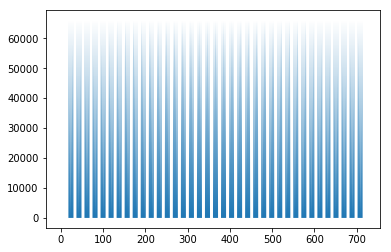

In [64]:
cur = lite.connect('singlereactortutorial.sqlite')

query = ("SELECT Time, Value FROM TimeSeriesUsedFuel")

#function get_tot_snf: takes query and cur
rawsnf_df = pd.read_sql_query(query, cur)
snf_df = rawsnf_df.drop_duplicates()

times = snf_df.Time.values

df = pd.DataFrame({'Total_Mass':np.zeros(duration+1)})
snf_df = pd.concat([snf_df,df], axis = 1)
snf_df = snf_df.drop(['Time','Value'],axis = 1)

for t in times:
    sumdmass = rawsnf_df.loc[(rawsnf_df.Time == t),'Value'].sum()
    snf_df.at[t,'Total_Mass'] = sumdmass
#end get_tot_mass, return snf_df

#add new columns for individual isotope mass
#to snf_df, and then can plot individual against total

# plot.area pandas option, but would have to remove the
#SimTime, which isn't used anyway.  graphs each column as
#stackedplot thingie  look into seaborn library to select
#colors, there is a colorblind option too